In [1]:
import nxsdk.api.n2a as nx
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
import pickle as p

In [2]:
import blackjackAgent
from analysis_functions import *

The most difficult problem the agent framework is currently demonstrated with is the card game 'blackjack.' In this game, the goal is to draw cards totaling 21 points without exceeding this limit. See [this article](https://en.wikipedia.org/wiki/Blackjack#Rules) for an overview of the rules. 

In [3]:
#in blackjack, all face cards (Jack, Queen, King) are scored the same so we are effectively left with 10 cards
n_cards = 10

#aces can be counted as 1 or 10 points, doubling the number of states in the game
n_states = n_cards**2 * 2
#a player can either hit (draw a card) or stick (refuse another card and 
# use the current sum to play against the dealer to end the round)
n_actions = 2
n_estimates = n_states * n_actions

In [4]:
l_epoch = 128
n_replicates = 2
episodes = 10000
runs = 5

In [5]:
#we will give the agent an initial policy to stick on a player sum of 20 or 21.
init_vals = np.zeros((n_actions,2,10,10,n_replicates),dtype=np.int)
init_vals[0,:,:,8:,:] = -1.0
init_vals[1,:,:,8:,:] = 1.0
init_vals *= (2**6) * 127

In [6]:
agent = blackjackAgent.BlackjackAgent(n_actions, 
                                      n_states, 
                                      n_replicates=n_replicates, 
                                      l_epoch=l_epoch, 
                                      n_epochs=episodes,
                                      starting_values = init_vals)

In [7]:
results = []

for i in range(runs):
    results.append(agent.run())
agent.board.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:42417
INFO:DRV:      Host server up..............Done 0.19s
INFO:DRV:      Encoding axons/synapses.....Done 1.79s
INFO:DRV:      Compiling Embedded snips....Done 0.44s
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1599597227.290658/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.02s
INFO:DRV:      Encoding probes.............Done 1.12ms
INFO:HST:  Lakemont_driver...
INFO:DRV:      Transferring probes.........Done 3.02ms
INFO:DRV:      Configuring registers.......Done 0.53s
INFO:DRV:      Transferring spikes.........Done 0.86ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
IN

We can inspect the state and action pairs which were taken by the agent during the learning process. Note that the action always comes after the state and categories in the table below are only arranged alphebetically. 

In [8]:
final_run = results[-1]
history = read_history(final_run[0])
history[-10:]

,Action,Dealer Card,Player Sum,Usable Ace
9990,Hit,10,19,True
9991,Stick,10,16,False
9992,Hit,5,19,False
9993,Stick,5,16,False
9994,Stick,10,16,False
9995,Hit,10,17,False
9996,Stick,4,12,True
9997,Hit,4,19,True
9998,Stick,7,15,True
9999,Hit,7,20,True


To inspect the policy which has been learned by the agent after play, we can look at the final on-chip estimates of value which are read back to the host after the run has been completed. 

In [9]:
fe = agent.final_estimates;
policy = data_to_policy({"final_estimates" : [agent.final_estimates], "conditions" : {"dynrange" : 1}})

In [10]:
optimal = open_julia_single("optimal.jld2","optimal")

Because there are only 2 actions in Blackjack (stick & hit), we can inspect policy by looking at the difference in value between the two. Below, we plot the learned difference in value between sticking & hitting. We expect this value to be very high when player sum is already close to 20 & 21, and this is observed. More advanced strategies for lower player sums also depend on the dealer card.

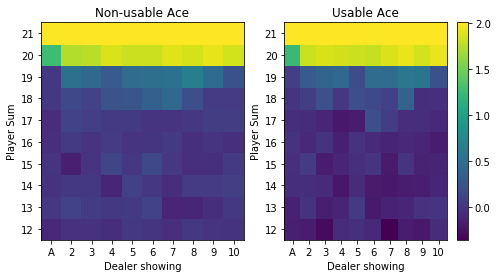

In [11]:
#Loihi values after 5e4 episodes
plot_policy(policy[0])

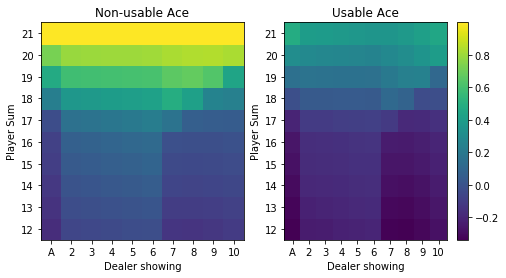

In [12]:
#CPU values after 2e6 episodes
plot_policy(optimal)

As a greedy policy is being used, we can use this value difference to directly calculate the policy. Anywhere the difference is greater than 0, the 'stick' action will be chosen. At this point (post 50,000 games) the agent is still approaching the optimal policy, but the gross aspects of the strategy (sticking on high values) are in place.

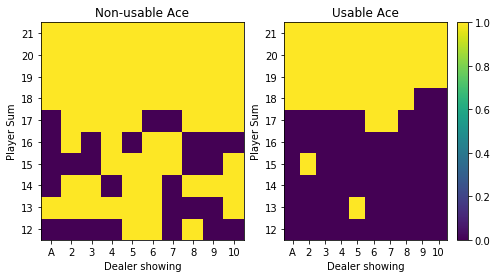

In [13]:
#Loihi policy after 5e4 episodes
plot_policy(policy[0] > 0.00)

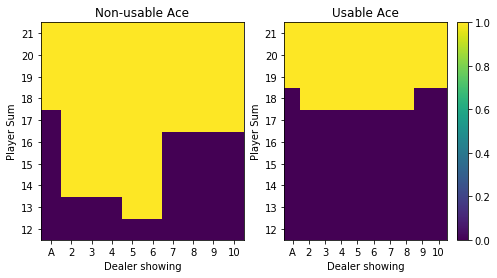

In [14]:
#CPU policy after 2e6 episodes
plot_policy(optimal > 0.00)